# Introduction

In this module, we will be covering implementation aspects of models of linear regression.

First we will learn linear regression models with
*  Normal equation, which estimates model parameter with a closed form solution and
*  Iterative optimization approach of gradient descent and its variants namely batch, mini-batch and stochastic gradient descent.  Here the model parameters are obtained by minimizing the loss function over training data.

Further we will study implementation of polynomial regression model, that is capable of modeling non-linear relationship between features and labels.  It mainly transforms the input features with a polynomial transformation of certain degree and then uses the linear regression model.

Since the polynomial regression uses more parameters (due to polynomial representation of the input), it is more prone to overfitting. We will study how to detect overfitting with learning curves and use of regularization to mitigate the risk of overfitting.

Let's start with essential imports:

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Linear regression

## Recap

Let's recall the components of linear regression:

1.  **Training data**: (features, label) or $(\mathbf{X}, y)$, where label $y$ is a real number.


2. **Model**: The label is obtained by linear combination (or weighted sum) of the input features and a *bias* (or *intercept*) term.

  \begin{eqnarray}
    \hat{y} = w_0 + w_1 x_1 + w_2 x_2 + \ldots + w_m x_m = \mathbf{w}^T \mathbf{x}
  \end{eqnarray}

  where,
  *  $\hat{y}$ is the predicted value
  *  $\mathbf{x}$ is a feature vector $\{x_1, x_2, \ldots, x_m\}$ for a given example with $m$ features in total
      * $i$-th feature: $x_i$
  *  Parameter vector $\mathbf{w}$ includes bias term too: $\{w_0, w_1, w_2, \ldots, w_m\}$
      * $w_i$ is $i$-the model parameter associated with $i$-the label.
  * $h_\mathbf{w}$ is a model with parameter vector $\mathbf{w}$.

In [ ]:
def predict(X, w):
  # Make sure features and weights have compatible shape.
  # Check to make sure that the shapes are compatible.
  assert X.shape[-1]==w.shape[0], "X and w don't have compatible dimensions"

  y = X @ w
  return y

 3. **Loss function**: The model parameters $\mathbf{w}$ are learnt such the difference between the actual and the predicted values is minimized.

 \begin{eqnarray}
    J(\mathbf{w}) &=& \frac{1}{2} \sum_{i=1}^n \left (y^{(i)} - \hat{y}^{(i)} \right ) \\
     &=& \frac{1}{2} \sum_{i=1}^n \left (y^{(i)} - \mathbf{w}^T \mathbf{x}^{(i)} \right )
 \end{eqnarray}

In [ ]:
def loss(features, labels, weights):
  e = labels - predict(features, weights)
  return (1/2) * (np.transpose(e) @ e)

4.  Optimization
  *  Normal equation
  *  Iterative optimization with gradient descent: full batch, mini-batch or stochastic

5. Evaluation measure
  *  Mean squared error (MSE)
  *  Root mean squared error (RMSE)

## Training set

### Generation

Let's implement linear regression model for a toy dataset to begin with.

>  Let's generate the dataset with the following specification:

In [ ]:
# Randomly sample 100 points.
X = 2 * np.random.rand(100, 1)

# Obtain y = 4 + 3*x + noise.  Noise is randomly sampled.
y = 4 + 3 * X + np.random.randn(100, 1)



### Exploration

> Let's quickly examine shapes of training and test sets:

In [ ]:
print ("Shape of feature matrix:", X.shape)
print ("Shape of label vector:", y.shape)

Shape of feature matrix: (100, 1)
Shape of label vector: (100, 1)


There are 100 examples in the training set and each example is represented with a single feature.

A few training examples can be examined as follows:

In [ ]:
# first 5 training examples and their labels.
# note that each example is represented with a single feature.
X[:5], y[:5]

(array([[0.74908024],
        [1.90142861],
        [1.46398788],
        [1.19731697],
        [0.31203728]]), array([[6.33428778],
        [9.40527849],
        [8.48372443],
        [5.60438199],
        [4.71643995]]))

### Visualization

> Let's visualize the data

(0.0, 2.0, 0.0, 15.0)

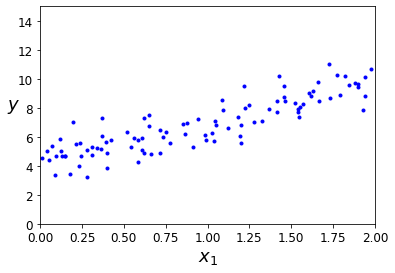

In [ ]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])

## Model

> Let's use linear regression model to learn relationship between $X$ and $y$.
*  In this case, we represent each training example with a single feature $x_1$.  We obtain label $y$ based on $x_1$ with the following model:
$$
 y = w_0 + w_1 x_1
$$

* This is a linear regression model with two parameters or weights: $w_o, w_1$.
* The weights are obtained via **normal equation** method based on the given training set:
$$
\mathbf{w} = \left( \mathbf{X}^T \mathbf{X} \right)^{-1} \mathbf{X}^T \mathbf{y}
$$



### Parameter estimation

Here we make use of estimator/predictor class `LinearRegression`.  As you may recall from sklearn introduction session, the estimators have `fit` method that takes dataset as an input along with any other hyperparameters and returns estimated parameters.


In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

> It's a good practice to scale or normalize features.  In case of this particular problem where we have a single feature, it does not matter.  However, for the sake of uniformity, we set flag `normalize` to `True` for normalizing the input features.

> While using the `LinearRegression` class object for estimating the model parameters, we do not need add a dummy column of 1's.  It is automatically added by setting `fit_intercept` parameter in the constructor to `True` by default.  In case, you do not want to learn the bias, you can choose to set it to `False`.


It's a good idea to check what more feature `LinearRegression` estimator/predictor offers from its help and [sklearn pages on `LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

In [ ]:
?LinearRegression

The following class methods are of our primary interests:
* `fit`: Fits linear model for a given training set.
* `predict`:  Predicts label for a new examples based on the learnt model.
* `score`: Returns $R^2$ of the linear regression model.


### Model inspection

*  Since we generated data with the following equation: $y = 4 + 3x_1+noise$, we know actual values of the parameters: $w_0 = 4$ and $w_1 = 3$.

*  We can compare these values with the estimated values.  Note that we do not have this luxury in real world problems, since we do not have access to the data generation process and its parameters.

*  There we rely on the evaluation metrics to assess quality of the model.

>  We can obtain them by accessing the following class variables of `LinearRegression` estimator:
  *  The intercept weight $w_0$ can be obtained via `intercept_` class variable.
  *  The weights corresponding to the features can be obtained via `coef_`class variable.

In [ ]:
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

We observe that the values of $w_0$ and $w_1$ are indeed close to the actual values (4 and 3 respectively) used for generating the data.

### Computational Complexity

*  The normal equation uses the following equation to obtain $\mathbf{w} = \left( \mathbf{X}^T \mathbf{X} \right)^{-1} \mathbf{X}^T \mathbf{y}$.
*  This involves matrix inversion operation of feature matrix $\mathbf{X}$.
*  The `LinearRegression` estimator uses SVD for this task and has complexity of $O(m^2)$ where $m$ is the number of features.
*  This implies that if we doubles the number of features, the training computation grows roughly 4 times.
  *  As the number of features grows large, the approach of normal equation slows down significantly.
  *  These approaches are linear w.r.t. the number of training examples.  As long as the training set fits in the memory.
*  The inference process is linear w.r.t. both the number of examples and number of features.

### Iterative optimization approach


### Gradient descent (GD)

* GD, as we studied in ML-T, is a very generic optimization algorithm that can be used for learning parameters of most of the ML models.

* GD obtains optimal parameters by making small changes to their values in each iteration proportional to the gradient of the loss function.

* Once GD reaches the minima of the loss function, we obtain the optimal parameters corresponding to the minima.


#### GD Algorithm

Two versions:
1.  non-vectorized: easy to understand and develop intuition
2.  vectorized: optimized and efficient

> Uses learning rate $\alpha$ as a hyperparameter to control parameter update.
  * Large $\alpha$: Large updates, leads to faster convergence or overshooting the minima of loss function
  * Small $\alpha$: Small updates, needs a lot more steps to reach the minima of loss function.

Selection of optimal $\alpha$ is an important problem to address for efficient training via GD.

Let's implement GD for the following model corresponding to the dataset we are experimenting with: $$y = w_0 + w_1 x_1$$

*  **Features**: X
*  **Labels**: y
*  **Loss**: Least square error
   \begin{eqnarray}
      J(w) &=&  \frac{1}{2} \sum_{i=1}^{n}(\mathbf{w}^T\mathbf{x}^{(i)} - y^{(i)})^2 \\
           &=& \frac{1}{2} \sum_{i=1}^{n}(w_0 + w_1 x_1^{(i)} - y^{(i)})^2
    \end{eqnarray}
*  **Objective**: Estimate $w_0$ and $w_1$ such that the loss incurred due to incorrect prediction is minimized.


**Non-vectorized GD [General form]**

1. Randomly initialize the parameter vector $\mathbf{w}$.  One possible initialization can be: $w_0 = 0, w_1 = 0, \ldots, w_m=0$.
2. Iterate until convergence:
   *  Calculate gradient of loss function w.r.t. the parameters $w_0$ and $w_1$ are $\frac{\partial J(\mathbf{w})}{\partial w_0}$ and $\frac{\partial J(\mathbf{w})}{\partial w_1}$ respectively.
   \begin{eqnarray}
      \frac{\partial J(\mathbf{w})}{\partial w_0} &=& \sum_{i=1}^{n} (w_0 + w_1 x_1^{(i)} + \ldots + w_m x_m^{(i)} - y^{(i)}) x_0^{(i)} \\
      &=& \sum_{i=1}^{n} (w_0 + w_1 x_1^{(i)} + \ldots + w_m x_m^{(i)} - y^{(i)}) \color{red}{1} \\
      \frac{\partial J(\mathbf{w})}{\partial w_1} &=& \sum_{i=1}^{n} (w_0 + w_1 x_1^{(i)} + \ldots + w_m x_m^{(i)} - y^{(i)}) x_1^{(i)} \\
      \vdots \\
      \frac{\partial J(\mathbf{w})}{\partial w_m} &=& \sum_{i=1}^{n} (w_0 + w_1 x_1^{(i)}+ \ldots + w_m x_m^{(i)} - y^{(i)}) x_m^{(i)}
   \end{eqnarray}
   *  Calculate updated parameters:
      *  \begin{eqnarray}
         w_0(\mathrm{new}) &:=& w_0 - \alpha \frac{\partial J(\mathbf{w})}{\partial w_0} \\
         w_1(\mathrm{new}) &:=& w_1 - \alpha \frac{\partial J(\mathbf{w})}{\partial w_1} \\
         \vdots \\
         w_m(\mathrm{new}) &:=& w_m - \alpha \frac{\partial J(\mathbf{w})}{\partial w_m}
         \end{eqnarray}
   *  Update parameters simultaneously:
      \begin{eqnarray}
         w_0 = w_0(\mathrm{new}) \\
         w_1 = w_1(\mathrm{new}) \\
         \vdots \\
         w_m = w_m(\mathrm{new})
         \end{eqnarray}

    After this step, the parameter vector gets new weights.

> Note that the parameters are updated to their new values together in the last step of GD. Until then the old values are used for predicting labels of examples while calculating the parameter updates.

In case of current problem, we need to estimate two parameters: $w_0$ and $w_1$.

**Vectorized GD**

1. Randomly initialize the parameter vector $\mathbf{w}$.
2. Iterate until convergence:
   *  Calculate gradient of loss function w.r.t. the parameter vector $\mathbf{w}$: $\dfrac{\partial J(\mathbf{w})}{\partial \mathbf{w}} = \color{blue} {\mathbf{X}^T  \left(\mathbf{X} \mathbf{w} - \mathbf{Y}\right)}$
   *  Calculate new parameter vector $\mathbf{w}(\mathrm{new}) := \mathbf{w}(\mathrm{old}) - \alpha \dfrac{\partial J(\mathbf{w})}{\partial \mathbf{w}}$
   *  Update parameter vector $\mathbf{w} = \mathbf{w}(\mathrm{new})$


> Note that vectorized and non-vectorized procedures perform identical work.  As we studied earlier, we prefer vectorized version for computational efficiency.

#### GD Convergence

>  The GD is said to converge when there is little change in the parameters in successive iterations.  Sometimes we wait for a few iterations to check if there is any change in the parameter vector.

>  We have an alternate criteria to terminate GD and that is based on the number of iterations.  We stop GD once it completes a fixed number of iterations.



There are two important practical questions for using GD:
1. How do we set the learning rate $\alpha$?
2. How do we decide the number of iterations?

Let's spend some time exploring options to address these questions in the context of current problem:

In [ ]:
X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance

# Let's use a couple of test examples.
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance

In [ ]:
X_b

array([[1.        , 0.74908024],
       [1.        , 1.90142861],
       [1.        , 1.46398788],
       [1.        , 1.19731697],
       [1.        , 0.31203728],
       [1.        , 0.31198904],
       [1.        , 0.11616722],
       [1.        , 1.73235229],
       [1.        , 1.20223002],
       [1.        , 1.41614516],
       [1.        , 0.04116899],
       [1.        , 1.9398197 ],
       [1.        , 1.66488528],
       [1.        , 0.42467822],
       [1.        , 0.36364993],
       [1.        , 0.36680902],
       [1.        , 0.60848449],
       [1.        , 1.04951286],
       [1.        , 0.86389004],
       [1.        , 0.58245828],
       [1.        , 1.22370579],
       [1.        , 0.27898772],
       [1.        , 0.5842893 ],
       [1.        , 0.73272369],
       [1.        , 0.91213997],
       [1.        , 1.57035192],
       [1.        , 0.39934756],
       [1.        , 1.02846888],
       [1.        , 1.18482914],
       [1.        , 0.09290083],
       [1.

#### Fixing learning rate

We typically perform grid search to search for an optimal learning rate:
1. Too small learning rate results in a very slow convergence.  In other words, it takes longer or more steps to reach the optimal solution.  Here the loss value changes very slowly between consecutive iterations.
2.  Too high learning rate may overshoot the optimal solution and may never converge.  This can be concluded by checking losses of consecutive steps.  In case the loss is increasing, we may have to lower the learning rate.

Typical learning rates tried are as follows:
*  We start with some value of $\alpha$, say 0.00001 and then change it to 10x in the next iteration and so on.
$$ \alpha = \{0.00001, 0.0001, 0.001, 0.01, 0.1, 1\}$$

In [ ]:
w_path_bgd = []

def plot_gradient_descent(w, lr, w_path=None):
    n = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    w_all = []

    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(w)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/n * X_b.T.dot(X_b.dot(w) - y)
        w = w - lr * gradients
        if w_path is not None:
            w_path.append(w)
        w_all.append(w)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\alpha = {}$".format(lr), fontsize=16)
    return w_all

Let's plot first 10 steps of gradient descent runs starting from the same point with three different learning rates or $\alpha$ values.


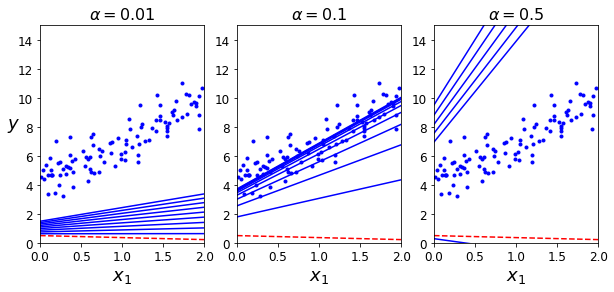

In [ ]:
np.random.seed(42)

w = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); w_all_small_alpha = plot_gradient_descent(w, lr=0.01)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); w_all_medium_alpha = plot_gradient_descent(w, lr=0.1,
                                                             w_path=w_path_bgd)
plt.subplot(133); w_all_large_alpha = plot_gradient_descent(w, lr=0.5)

plt.show()

After first 10 iterations of GD, we observe the following convergence behaviour for different learning rates:
1. For the lowest learning rate $\alpha = 0.01$, we are still away from reaching the optimal model.
2. For the highest learning rate $\alpha = 0.5$, we have moved past the optimal solution and moving further away with each iteration.
3. For a moderate learning rate of $\alpha=0.1$, we converged to the optimal solution.

> Note: Such exploration is possible for a toy problem, in real world problems with more features, we rely on learning curves to make judgement about learning and convergence.

More generally, we make use of learning curves to study the effect of learning rate on convergence.   For this,
*  Calculate loss in every iteration - as the weights change - the loss also changes.
*  Plot learning curve - loss for each iteration.


In [ ]:
def get_err_path(X, y, w_list):
  err = []
  for w in w_list:
    err.append(loss(X_b, y, w)[0][0])
  return err

In [ ]:
err_path_small_alpha = get_err_path(X_b, y, w_all_small_alpha)
err_path_medium_alpha = get_err_path(X_b, y, w_all_medium_alpha)
err_path_large_alpha = get_err_path(X_b, y, w_all_large_alpha)

In [ ]:
def plot_learning_curves(beg, end, err, lr):
    plt.plot(range(beg, end), err[beg:end], "b-s", linewidth=1)
    plt.xlabel("iter #", fontsize=18)
    plt.title(r"$\alpha = {}$".format(lr), fontsize=16)

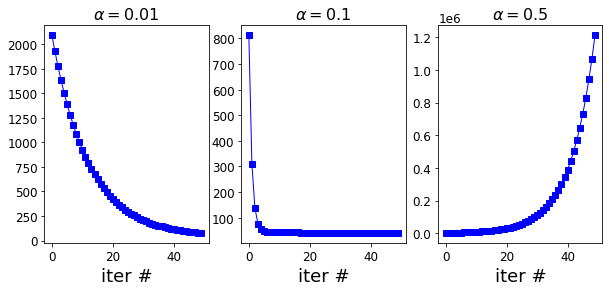

In [ ]:
plt.figure(figsize=(10,4))
plt.ylabel(r"$J(\mathbf{w})$   ", fontsize=20, rotation=90)
plt.subplot(131); plot_learning_curves(0, 50, err_path_small_alpha, 0.01)
plt.subplot(132); plot_learning_curves(0, 50, err_path_medium_alpha, 0.1)
plt.subplot(133); plot_learning_curves(0, 50, err_path_large_alpha, 0.5)
plt.show()

In [ ]:
def compute_gradient_descent(w, lr, w_path=None):
    n = len(X_b)
    # plt.plot(X, y, "b.")
    n_iterations = 1000
    w_all = []

    for iteration in range(n_iterations):
        # if iteration < 10:
        #     y_predict = X_new_b.dot(w)
        #     style = "b-" if iteration > 0 else "r--"
        #     plt.plot(X_new, y_predict, style)
        gradients = 2/n * X_b.T.dot(X_b.dot(w) - y)
        w = w - lr * gradients
        if w_path is not None:
            w_path.append(w)
        w_all.append(w)
    # plt.xlabel("$x_1$", fontsize=18)
    # plt.axis([0, 2, 0, 15])
    # plt.title(r"$\alpha = {}$".format(lr), fontsize=16)
    return w_all

In [ ]:
# compute GD trajectories fore different learning rates
w_path_small_lr = []
w_path_medium_lr = []
w_path_large_lr = []

w_path_small_lr = compute_gradient_descent(w, 0.01, w_path=w_path_small_lr)
w_path_medium_lr = compute_gradient_descent(w, 0.1, w_path=w_path_medium_lr)
w_path_large_lr = compute_gradient_descent(w, 0.5, w_path=w_path_large_lr)

w_path_small_lr = np.array(w_path_small_lr)
w_path_medium_lr = np.array(w_path_medium_lr)
w_path_large_lr = np.array(w_path_large_lr)

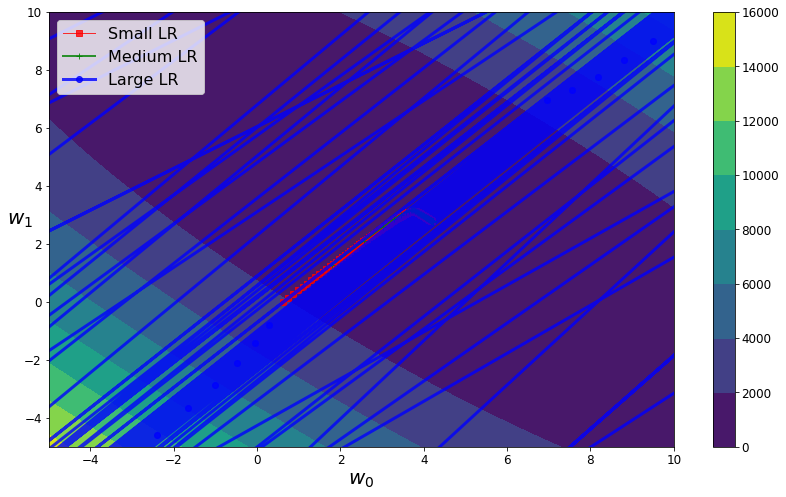

In [ ]:
fig = plt.figure(figsize=(14,8))

plt.plot(w_path_small_lr[:, 0], w_path_small_lr[:, 1], "r-s", linewidth=1, label="Small LR", alpha=0.8)
plt.plot(w_path_medium_lr[:, 0], w_path_medium_lr[:, 1], "g-+", linewidth=2, label="Medium LR", alpha=0.8)
plt.plot(w_path_large_lr[:, 0], w_path_large_lr[:, 1], "b-o", linewidth=3, label="Large LR", alpha=0.8)

plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$w_0$", fontsize=20)
plt.ylabel(r"$w_1$", fontsize=20, rotation=0)
plt.axis([-5, 10, -5, 10])

xmin, xmax, ymin, ymax = plt.axis()

tx = np.linspace(xmin, xmax, 200)
ty = np.linspace(ymin, ymax, 200)
X_train_with_dummy = np.concatenate((np.ones_like(X), X) ,axis=1)
xx,yy=np.meshgrid(tx,ty)
zz = np.array([loss(X_train_with_dummy,y.ravel(),np.array([mp,bp])) for mp, bp in zip(xx.ravel(), yy.ravel())])
zz = zz.reshape(xx.shape)

plt.contourf(xx,yy,zz)
plt.colorbar()

plt.show()

Observations:
*  After first 50 iterations, the learning curve for $\alpha=0.1$ (middle one) has the lowest loss.  The loss decreases rapidly and flattens out after 10-th iteation.
*  The loss in the learning curve for $\alpha=0.01$ slowly decreases.
*  The loss in case of $\alpha=0.5$ rather increases.


By observing learning curves, we get valuable insights into model training:
  *  In case, the loss does not reduce after initial few iterations, we perhaps need to increase the learning rate so that the learning proceeds a bit faster.  Stop the training, increase the learning rate and restart the training and again observe the learning rate.
  *  In case the loss increases, it means the learning rate is too large and we need to reduce it.  Stop the training, decrease the learning rate and restart the training and again observe the learning rate.




#### Fixing the number of iterations

* **Too few iterations:** not enough iterations to reach the optimal solution.
* **Too many iterations:** once we reach the optimal solution, we end up wasting computational cycles as subsequent runs hadly result in any changes in the parameters.

> In practice, we set the number of iterations to a sufficiently large number, but add a convergence criteria which terminates GD loop as soon as the gradient vector becomes smaller than some threhold $\epsilon$.

### Mini-batch GD

Let's look at the gradient computation step in GD:

> \begin{equation}
\frac{\partial J(\mathbf{w})}{\partial w_j} = \sum_{i=1}^{n} (w_0 + w_1 x_1^{(i)} + \ldots + w_m x_m^{(i)} - y^{(i)}) x_j^{(i)}
\end{equation}

Notice the summation term: We need to iterate over the entire training set to compute the gradient.  And this needs to be done for every single feature.

> However training examples are independent and identically distributed and this can be exploited in mini-batch GD for faster updates.

The key idea is to use a small batch of examples for calculating the gradient in each iteration.  We will explore it in detail in a few moments.

All steps are like GD except each step processes a small number of examples rather the full set.

1. Randomly initialize the parameter vector $\mathbf{w}$.
2. Iterate until convergence:
   *  Divide the dataset into $k$ batches
   *  **for every batch**:
    *  Calculate gradient of loss function w.r.t. the parameters same as in GD
    *  Update parameters: Same as GD
    *  Update parameters simultaneously: Same as GD

The following terminology is used in general:
1. In mini-batch gradient descent, we process $k$ examples in each iteration.
2. One full pass over the training set is called an **epoch**.  An epoch needs total of $\frac{n}{k}$ iterations or in a single epoch the parameters are updated $\frac{n}{k}$ times.

In [ ]:
n = len(X_b)
np.random.seed(42)

We use learning schedule for mini-batch and SGD.
*  It enables us to use different learning rates based on the interation count.
*  At the start, we use larger learning rate, but as we progress with our learning and move closer and closer to the minima, we would like to reduce the learning rate so as to allow algorithms to settle at the minima.

We need to be cautious while setting up the learning schedule in order to avoid getting stuck at suboptimal solution or falling short of reaching the minima.

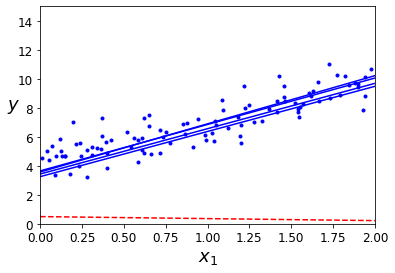

In [ ]:
w_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
w = np.random.randn(2,1)  # random initialization


t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0

for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(n)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, n, minibatch_size):
      if epoch == 0 and i < 100:
          y_predict = X_new_b.dot(w)
          style = "b-" if i > 0 else "r--"
          plt.plot(X_new, y_predict, style)
      t += 1
      xi = X_b_shuffled[i:i+minibatch_size]
      yi = y_shuffled[i:i+minibatch_size]
      gradients = 2/minibatch_size * xi.T.dot(xi.dot(w) - yi)
      lr = learning_schedule(t)
      w = w - lr * gradients
      w_path_mgd.append(w)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

> Let's look at the weight vector obtained from mini-batch GD

In [ ]:
w

array([[4.25214635],
       [2.7896408 ]])

### Stochastic gradient descent

When we use $k = 1$ in mini-batch GD, it is called stochastic gradient descent (SGD).

In [ ]:
w_path_sgd = []

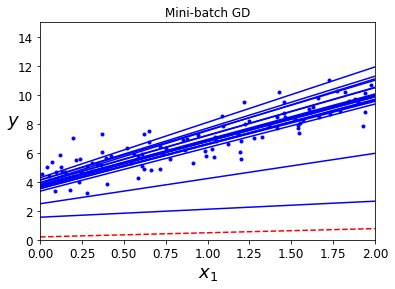

In [ ]:
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

# random initialization of weight vector
w = np.random.randn(2,1)

for epoch in range(n_epochs):
    for i in range(n):
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(w)
            style = "b-" if i > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        random_index = np.random.randint(n)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(w) - yi)
        lr = learning_schedule(epoch * n + i)
        w = w - lr * gradients
        w_path_sgd.append(w)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.title('Mini-batch GD')
plt.axis([0, 2, 0, 15])
plt.show()

> Let's look at the weight vector obtained from mini-batch GD


In [ ]:
w

array([[4.19014548],
       [2.78071245]])

### Convergence characteristics of GD, MBGD and SGD

Let's investigate convergence characteristics of different iterative optimization algorithms.
*  Plot the trajectory of optimization algorithm in the weights' space. In other word, plot the weights as obtained from the first to the last iteration in that order.
*  Observe the trajectory of three variants and compare it with one another.

In [ ]:
w_path_bgd = np.array(w_path_bgd)
w_path_sgd = np.array(w_path_sgd)
w_path_mgd = np.array(w_path_mgd)

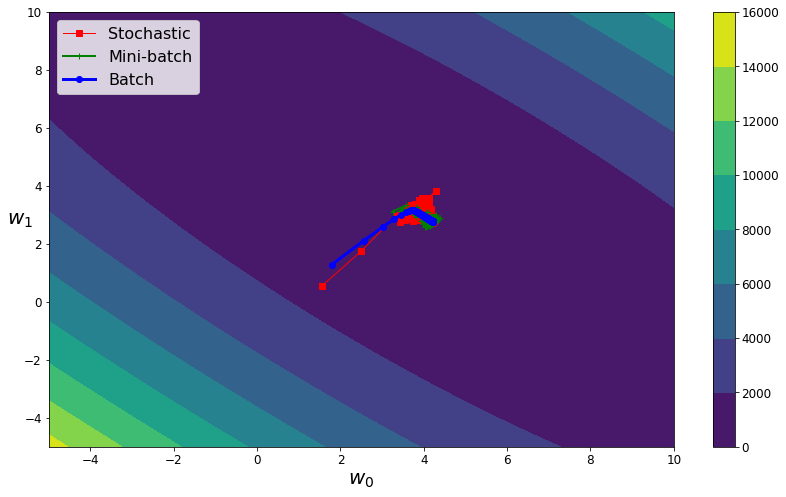

In [ ]:
fig = plt.figure(figsize=(14,8))

plt.plot(w_path_sgd[:, 0], w_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(w_path_mgd[:, 0], w_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(w_path_bgd[:, 0], w_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")

plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$w_0$", fontsize=20)
plt.ylabel(r"$w_1$", fontsize=20, rotation=0)
plt.axis([-5, 10, -5, 10])

xmin, xmax, ymin, ymax = plt.axis()

tx = np.linspace(xmin, xmax, 200)
ty = np.linspace(ymin, ymax, 200)
X_train_with_dummy = np.concatenate((np.ones_like(X), X) ,axis=1)
xx,yy=np.meshgrid(tx,ty)
zz = np.array([loss(X_train_with_dummy,y.ravel(),np.array([mp,bp])) for mp, bp in zip(xx.ravel(), yy.ravel())])
zz = zz.reshape(xx.shape)

plt.contourf(xx,yy,zz)
plt.colorbar()

plt.show()

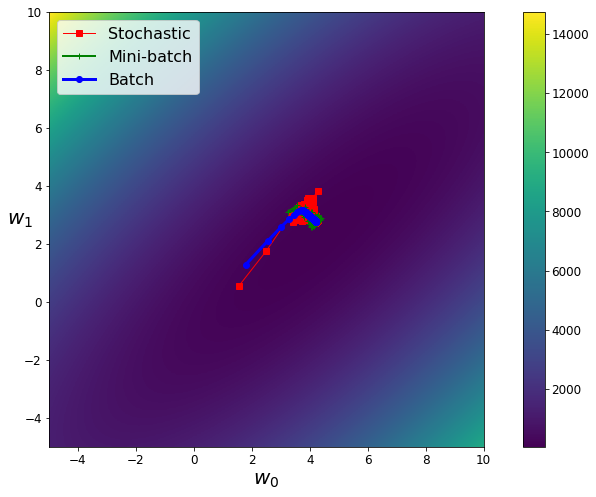

In [ ]:
fig = plt.figure(figsize=(14,8))

plt.plot(w_path_sgd[:, 0], w_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(w_path_mgd[:, 0], w_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(w_path_bgd[:, 0], w_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")

plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$w_0$", fontsize=20)
plt.ylabel(r"$w_1$", fontsize=20, rotation=0)
plt.axis([-5, 10, -5, 10])

xmin, xmax, ymin, ymax = plt.axis()

tx = np.linspace(xmin, xmax, 200)
ty = np.linspace(ymin, ymax, 200)
X_train_with_dummy = np.concatenate((np.ones_like(X), X) ,axis=1)
xx,yy=np.meshgrid(tx,ty)
zz = np.array([loss(X_train_with_dummy,y.ravel(),np.array([mp,bp])) for mp, bp in zip(xx.ravel(), yy.ravel())])
zz = zz.reshape(xx.shape)

plt.imshow(zz,extent=plt.axis())
plt.colorbar()

plt.show()

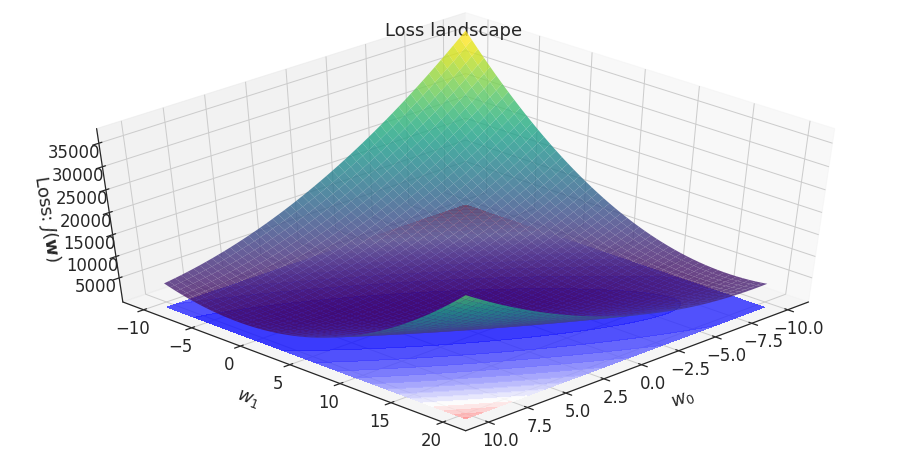

In [ ]:
#rough
y_train=y
X_train_with_dummy = np.concatenate((np.ones_like(X), X),axis=1)
from mpl_toolkits.mplot3d import Axes3D
import collections
import seaborn as sns
sns.set_style("white")

fig = plt.figure(figsize=(16, 8))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

# fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')

w_1 = np.linspace(-10, 10, 200)
w_0 = np.linspace(-10, 20, 200)

W_1, W_0 = np.meshgrid(w_1, w_0)
zs = np.array([
              #  np.sum((y_train - np.dot(X_train_with_dummy, np.array([bp, mp])[:,None]))**2)/2
               loss(X_train_with_dummy, y_train.ravel(), np.array([bp, mp]))
               for mp, bp in zip(np.ravel(W_1), np.ravel(W_0))])
Z = zs.reshape(W_1.shape)
ax.plot_surface(W_1, W_0, Z, cmap='viridis',edgecolor='none',alpha=0.8)

ax.set_xlabel('$w_0$', labelpad=20)
ax.set_ylabel('$w_1$', labelpad=20)
ax.set_zlabel('Loss: $J(\mathbf{w})$', rotation=90, labelpad=10)
ax.view_init(elev=45.0, azim=45)


# ax.plot([4], [3], [loss(X_train_with_dummy, y_train, np.array([4, 3]))[4][3]],
#         markerfacecolor='y', markeredgecolor='r', marker='o', markersize=10)
ax.contourf(W_1, W_0, Z,levels=20,zdir='z',cmap='bwr',offset=-2000,alpha=0.8)
plt.title('Loss landscape')

plt.show()

A few points strike while observing paths taken by different variants of GDs:
*  All optimizers end up around the actual minima.  The path by batch GD ends in the minima, while the other two variants end up around minima.  They can reach the minima in case we use appropriate learning schedule.



In [ ]:
print ("Parameters obtained by batch gradient descent:", w_path_bgd[-1])
print ("Parameters obtained by mini-batch gradient descent:", w_path_mgd[-1])
print ("Parameters obtained by stochastic gradient descent:", w_path_sgd[-1])

Parameters obtained by batch gradient descent: [[4.21509616]
 [2.77011339]]
Parameters obtained by mini-batch gradient descent: [[4.25214635]
 [2.7896408 ]]
Parameters obtained by stochastic gradient descent: [[4.19014548]
 [2.78071245]]


*  They travel different paths to arrive at the optimal solution.
    * Batch GD have a smooth path to the minima, though it takes longer time to reach there.
    *  SGD is more erratic in its path than mini-batch GD.  This is due to the fact that SGD computes weight updates based on a single example as against $k$ examples used in mini-batch GD.

Let's examine learning curves of three variants of GD:
*  Calculate training loss at an instance of a weight vector obtained in each iteration with `get_err_path` function.  There would be one value of loss computed at each interation based on the weight vector.


In [ ]:
err_path_bgd = get_err_path(X_b, y, w_path_bgd)
err_path_sgd = get_err_path(X_b, y, w_path_sgd)
err_path_mgd = get_err_path(X_b, y, w_path_mgd)

*  Plot the loss for each iteration

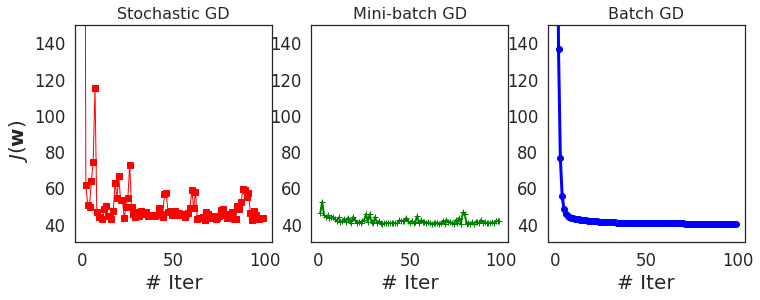

In [ ]:
# modify first two lines to see
last_iter = 100
start_iter = 1
last_iter_mgd = min(last_iter, len(err_path_mgd))
last_iter_bgd = min(last_iter, len(err_path_bgd))
last_iter_sgd = min(last_iter, len(err_path_sgd))

plt.figure(figsize=(12,4))
plt.subplot(131); plt.plot(
    range(start_iter, last_iter_sgd), err_path_sgd[start_iter:last_iter_sgd],
    "r-s", linewidth=1, label="Stochastic")
plt.ylabel(r"$J(\mathbf{w})$   ", fontsize=20, rotation=90)
plt.ylim([30, 150])
plt.title(r"Stochastic GD", fontsize=16)
plt.xlabel(r"# Iter", fontsize=20)
plt.subplot(132); plt.plot(
    range(start_iter, last_iter_mgd), err_path_mgd[start_iter:last_iter_mgd],
     "g-+", linewidth=2, label="Mini-batch")
plt.ylim([30, 150])
plt.title(r"Mini-batch GD", fontsize=16)
plt.xlabel(r"# Iter", fontsize=20)
plt.subplot(133);
plt.plot(
    range(start_iter, last_iter_bgd), err_path_bgd[start_iter:last_iter_bgd],
    "b-o", linewidth=3, label="Batch")
plt.ylim([30, 150])
plt.title(r"Batch GD", fontsize=16)
plt.xlabel(r"# Iter", fontsize=20)

plt.show()

In [ ]:
# rough
print(err_path_bgd)

[812.5844566556232, 309.8867645070658, 136.44459760096777, 76.46698447067806, 55.59941418663703, 48.221147578974104, 45.503340766607515, 44.40306748428442, 43.87106770445678, 43.54507622308892, 43.29958918575306, 43.09072725935021, 42.90277826393747, 42.729774937702054, 42.56914468446509, 42.41951905011218, 42.27997665016598, 42.14978016438625, 42.02828371159863, 41.91489906485425, 41.809082265530456, 41.7103273825846, 41.6181628424318, 41.532148745983164, 41.45187462047478, 41.37695740944465, 41.3070396272073, 41.24178764694739, 41.1808901066582, 41.124056422698295, 41.071015402970474, 41.021513952794464, 40.97531586719102, 40.93220070377765, 40.89196273088517, 40.854409945871076, 40.81936315894458, 40.78665513813035, 40.75612981129146, 40.72764152140337, 40.701054331525576, 40.67624137615426, 40.653084255861025, 40.631472472328994, 40.61130290109038, 40.59247929944978, 40.57491184724508, 40.55851671825454, 40.54321568020503, 40.52893572147293, 40.51560870269613, 40.503171031634935, 4

> Observations:
*  Batch GD has the smoothest learning curve: the loss reduces continuously iterations after iterations.
*  The learning curves corresponding to mini-batch GD and SGD show ups and downs in loss.  In some iteration, the loss reduces and then in the next one it goes up.  Overall the losses are on downward trajectory.
*  As the batch size increases, the resulting learning curves become smoother for a given configuration of hyperparameters like learning rate.

### SGDRegressor | [sklearn page](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html?highlight=sgdregressor#sklearn.linear_model.SGDRegressor)

* Performs parameter estimation of linear regression models with SGD by optimizing the squared error loss.
* A few parameters:
  * `fit_itercept`: Whether the intercept should be estimated or not.
  * `shuffle`: Whether or not the training data should be shuffled after each epoch.
  * `max_iter`: Maximum number of iterations.
  * `tol`: Tolerence for drop in loss in successive iterations (convergence criteria).
  * `eta0`: Learning rate at the start.
  * `penalty`: Regularization.
  * `learning_rate`: Learning rate schedule.

> SGD runs for `max_iter` number of iterations or until the loss drops by less than `tol` during one epoch.

In [ ]:
from sklearn.linear_model import SGDRegressor

Alternatively we can also get an instance help in colab with the following command for this predictor.

In [ ]:
?SGDRegressor

In [ ]:
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)

In [ ]:
?y.ravel()

We can check `y` before and after `ravel`.

In [ ]:
y

array([[ 6.33428778],
       [ 9.40527849],
       [ 8.48372443],
       [ 5.60438199],
       [ 4.71643995],
       [ 5.29307969],
       [ 5.82639572],
       [ 8.67878666],
       [ 6.79819647],
       [ 7.74667842],
       [ 5.03890908],
       [10.14821022],
       [ 8.46489564],
       [ 5.7873021 ],
       [ 5.18802735],
       [ 6.06907205],
       [ 5.12340036],
       [ 6.82087644],
       [ 6.19956196],
       [ 4.28385989],
       [ 7.96723765],
       [ 5.09801844],
       [ 5.75798135],
       [ 5.96358393],
       [ 5.32104916],
       [ 8.29041045],
       [ 4.85532818],
       [ 6.28312936],
       [ 7.3932017 ],
       [ 4.68275333],
       [ 9.53145501],
       [ 5.19772255],
       [ 4.64785995],
       [ 9.61886731],
       [ 7.87502098],
       [ 8.82387021],
       [ 5.88791282],
       [ 7.0492748 ],
       [ 7.91303719],
       [ 6.9424623 ],
       [ 4.69751764],
       [ 5.80238342],
       [ 5.34915394],
       [10.20785545],
       [ 6.34371184],
       [ 7

In [ ]:
y.ravel()

array([ 6.33428778,  9.40527849,  8.48372443,  5.60438199,  4.71643995,
        5.29307969,  5.82639572,  8.67878666,  6.79819647,  7.74667842,
        5.03890908, 10.14821022,  8.46489564,  5.7873021 ,  5.18802735,
        6.06907205,  5.12340036,  6.82087644,  6.19956196,  4.28385989,
        7.96723765,  5.09801844,  5.75798135,  5.96358393,  5.32104916,
        8.29041045,  4.85532818,  6.28312936,  7.3932017 ,  4.68275333,
        9.53145501,  5.19772255,  4.64785995,  9.61886731,  7.87502098,
        8.82387021,  5.88791282,  7.0492748 ,  7.91303719,  6.9424623 ,
        4.69751764,  5.80238342,  5.34915394, 10.20785545,  6.34371184,
        7.06574625,  7.27306077,  5.71855706,  7.86711877,  7.29958236,
        8.82697144,  8.08449921,  9.73664501,  8.86548845,  6.03673644,
        9.59980838,  3.4686513 ,  5.64948961,  3.3519395 ,  7.50191639,
        5.54881045,  5.30603267,  9.78594227,  4.90965564,  5.91306699,
        8.56331925,  3.23806212,  8.99781574,  4.70718666, 10.70

The `ravel` function flattens the array.

> Let's train the model with the training data via `fit` method.

In [ ]:
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

We can obtain the parameters of the model as follows:
*  The intercept weight $𝑤_0$  can be obtained via `intercept_` class variable.
*  The weights corresponding to the features can be obtained via `coef_class_` variable.

In [ ]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.24269195]), array([2.82419221]))

We observe that the values of $w_0$ and $w_1$ are indeed close to the actual values (4 and 3 respectively) used for generating the data.

## Comparison of `LinearRegressor` and `SGDRegressor`

| Parameters | `LinearRegressor`  | `SGDRegressor`  |
| -----------| ------------------- | ----------------|
| Method     | SVD                 | SGD             |
| Scaling | Not needed       | Needed          |
| Large data training  | Fast  | Fast          |
| Large features training | Slow | Fast |
| # hyperparameters  | 0 | $\ge 2$ |

Let's compare the parameters obtained by these two methods on our toy dataset:

**`LinearRegressor`**

In [ ]:
print ("Intercept:", lin_reg.intercept_)
print ("Coefficients:", lin_reg.coef_)

Intercept: [4.21509616]
Coefficients: [[2.77011339]]


**SGDRegressor**

In [ ]:
print ("Intercept:", sgd_reg.intercept_)
print ("Coefficients:", sgd_reg.coef_)

Intercept: [4.24269195]
Coefficients: [2.82419221]


The parameter vectors are very close.

# Polynomial regression

*  Whenever there is a non-linear relationship between input features and output labels, linear regression does not work.

*  We need polynomial regression models in such cases.

*  We will study how to implement polynomial models of regression with sklearn API.

As usual, we will first demonstrate the use of polynomial regression on a toy dataset, which is generated by the following code snippet:

$$
  y = 0.5 x_1^2 + x_1 + 2 + noise
$$

In [ ]:
def generate_nonlinear_mapping(num_examples):
  X = 6 * np.random.rand(num_examples, 1) - 3
  y = 0.5 * X**2 + X + 2 + np.random.randn(num_examples, 1)
  return X, y

(-3.0, 3.0, 0.0, 10.0)

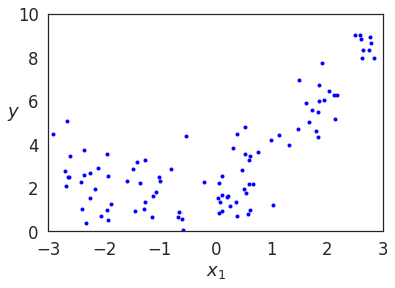

In [ ]:
n = 100
X, y = generate_nonlinear_mapping(n)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])

*  A quick visual inspection suggests that the straight line won't be able to fit the training data properly.

*  Let's try polynomial regression in this case:
  * Construct polynomial features by using `sklearn.preprocessing.PolynomialFeatures` transformer.  We use polynomial features transformation of degree 2.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

Let's examine the features before and after tranformation:

In [ ]:
print ("Original feature:", X[0])
print ("Transformed feature:", X_poly[0])

Original feature: [-2.31489732]
Transformed feature: [-2.31489732  5.3587496 ]


Observe that an additional feature has been added, which is square of the original feature.

  * Apply linear regression model on the polynomial features.

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.82924031]), array([[1.03676627, 0.55836915]]))

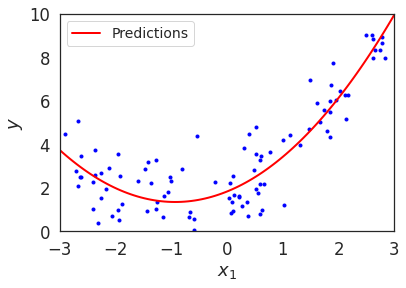

In [ ]:
# generates 100 test samples between -3 and 3.
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

# plot the training set
plt.plot(X, y, "b.")

# plot the predictions for the generated samples.
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=90, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

Whenever there are more than 1 feature, the `PolynomialFeatures` constructs new features that also includes combination of features up to a given degree and raising powers of individual features to a given degree.

> The total number of features constructed from $m$ features with `PolynomialFeatures(degree=d)` = $\dfrac{(n+d)!}{d!n!}$



The number of features grow exponentially with polynomial feature transformation.
*  These features enable us to obtain a far better model than a simple linear model.
*  Aggressive use of polynomial features may lead to overfitting of the model.

Let's use polynomial features of degree 2 and 100 (equal to the number of points in the training set) and examine the resulting models.

> We make use of `Pipeline` class to chain transforms with the model in the end.  This is how you should code going forward.

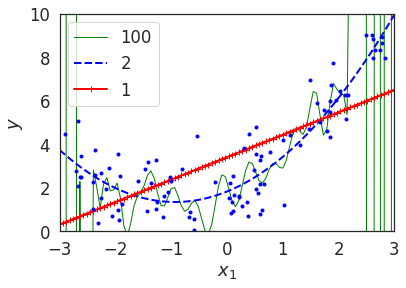

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 100), ("b--", 2, 2), ("r-+", 2, 1)):
    polynomial_regression = Pipeline([
            ("poly_features", PolynomialFeatures(degree=degree, include_bias=False)),
            ("std_scaler", StandardScaler()),
            ("lin_reg", LinearRegression()),
        ])
    polynomial_regression.fit(X, y)
    y_new_hat = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_new_hat, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=90, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

* Observations:
  * The model for polynomial regression with $degree=100$ wiggles around to fit the training data as close as possible.
  *  The models with lower polynomial degree are smooth - they do not try hard to fit the training data and have a better chance to generalize.

> How do we judge the generalization performance of the model?

Learning curves is the tool in our toolkit that helps us judge that.  Let's understand how to use it.

*  By checking training and validation loss across iterations.  Initially both decrease, but then
  * Training and validation errors do not reduce further and end up being in the higher zone. This points towards model **underfitting**.
  * Training error continues to reduce, but the validation error starts increasing after certain point.  This points towards **overfitting**.

*  By plotting loss as a function of the size of the training set.
  * Train model several times with training set of different size.
  * Calculate training and validation losses for the trained model and plot them.

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    # divide the data into train and validation sets.
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)


Let's plot learning curves for linear regression model as a function of size of the training set.

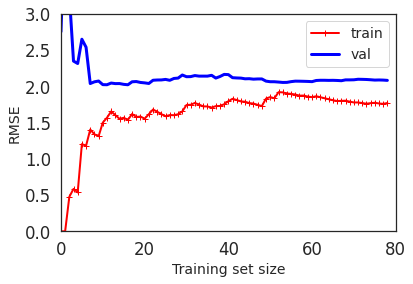

In [ ]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

Observe that
*  For smaller sizes of the training set the training error is small and as the size increases, the error also increasing before stabilizing.
  * For initial one or two points the model fits the data perfectly and hence zero training error.
*  The validation error is starts higher and then reduces as the size of the training set increases before stabilizing.
  * When the size of the training set is small, the model is unable to generalize well and hence the validation error is high.

> In this case we observe that both errors are fairly high and close, which indicates model underfitting.

What is the remedy?

Make use a more complex model or obtain features that can represent the training data in a better manner.

> Let's fit the model with polynomial of degree 12.

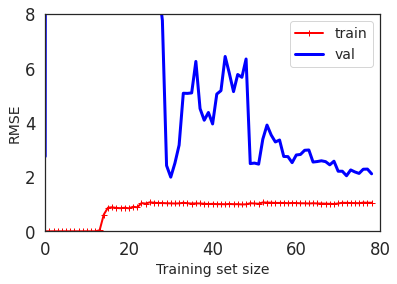

In [ ]:
from sklearn.pipeline import Pipeline

poly_reg = Pipeline([
        ("poly_features", PolynomialFeatures(degree=12, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(poly_reg, X, y)
plt.axis([0, 80, 0, 8])
plt.show()

Observe that the training error is much lower than the validatio error and there is a gap between two curves.  Such a learning curve indicates overfitting issue in the model.

> What is the remedy?
  *  More data
  *  Reduce the model complexity by reducing features or even better using regularization.



We had generated the training data with the second order polynomial and we would like to examine learning curves for the second order polynomials.

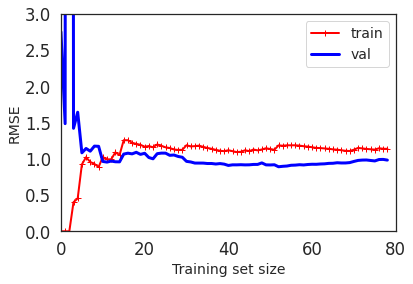

In [ ]:
from sklearn.pipeline import Pipeline

poly_reg = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(poly_reg, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

What do you observe here?
*  Training and validation errors have stablized to lower values as the size of training set increases.

# *Regularization*

Let's tackle the issue of overfitting in the model by adding constrains on the weights through:
1. Ridge regression
2. Lasso regression

> We add a penalty term based on the norm of the weight vector to the loss function and optimize the resulting constrained loss function.

### Ridge regression

* We add second norm of the weight vector to the loss function: $$J(\mathbf{w}) = \frac{1}{2} \sum_{i=1}^{n} (\mathbf{w}^T \mathbf{x}^{(i)} - y^{(i)})^2 + \frac{\lambda}{2}  \sum_{i=1}^{m} w_i^2 $$
* The optimizer now has dual responsibility - keeping the loss to optimal level while keeping the norm of the weight vector as small as possible.  This prevents optimal model fit by arbitrary high weights assigned to a few parameters.
* Even though the regularization term is added to loss function during training, the performance of the trained model is evaluated using unregularized loss function.



In sklearn API, ridge regressiom can be carried out either using
*  the method of normal equation with `sklearn.linear_model.Ridge` predictor using `cholesky` solver or
*  iterative optimization with `sklearn.linear_model.SGDRegressor` predictor by setting `penalty` parameter to `l2`.

In [ ]:
# with ridge regression
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver='cholesky')
ridge_reg.fit(X, y)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='cholesky', tol=0.001)

Let's examine the parameters of the model as learnt through the ridge regressor.

In [ ]:
ridge_reg.intercept_

array([3.4144244])

In [ ]:
ridge_reg.coef_

array([[1.02905095]])

Now we need to set optimal $\lambda$.  We have studied that
*  $\lambda = 0$, reduces the model to the classical linear regression model.
*  A large value of $\lambda$ leads to a highly biased model that passes through the mean value of the label.  It completely disregards the training data while optimizing the loss function.

> We need to set $\lambda$ between these two extremes.



> It is important to scale the data before applying ridge regression.  It is sensitive to the scale of the input features.

Let's study the effect of different values of $\lambda$ on the learned model.

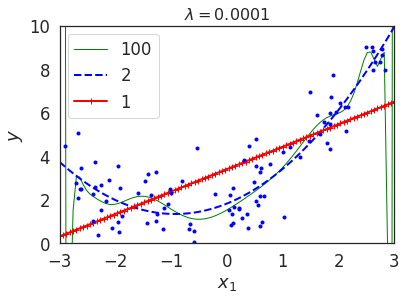

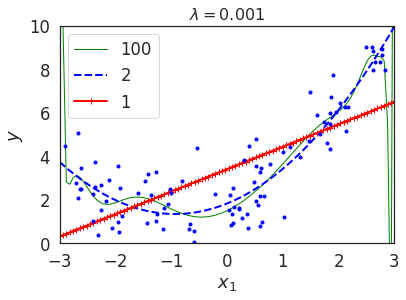

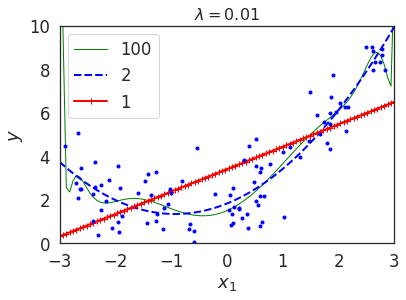

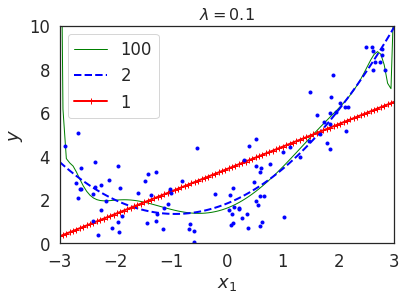

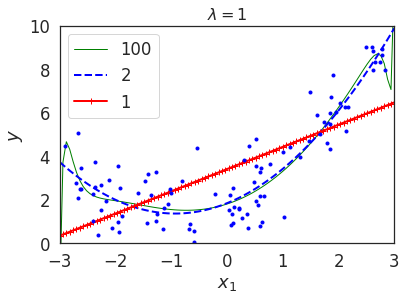

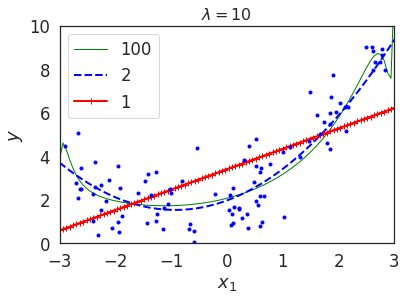

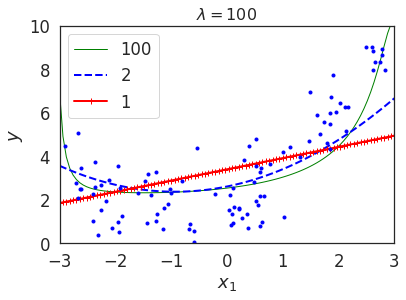

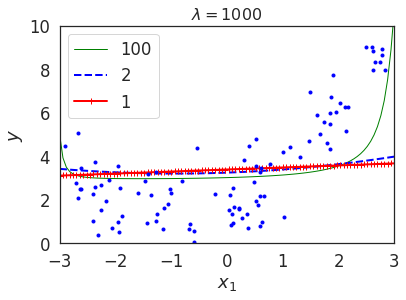

In [ ]:
for rr in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]:
  for style, width, degree in (("g-", 1, 100), ("b--", 2, 2), ("r-+", 2, 1)):
      polynomial_regression = Pipeline([
              ("poly_features", PolynomialFeatures(degree=degree, include_bias=False)),
              ("std_scaler", StandardScaler()),
              ("ridge_reg", Ridge(alpha=rr, solver='cholesky')),
          ])
      polynomial_regression.fit(X, y)
      y_new_hat = polynomial_regression.predict(X_new)
      plt.plot(X_new, y_new_hat, style, label=str(degree), linewidth=width)

  plt.plot(X, y, "b.", linewidth=3)
  plt.legend(loc="upper left")
  plt.xlabel("$x_1$", fontsize=18)
  plt.ylabel("$y$", rotation=90, fontsize=18)
  plt.title(r"$\lambda = {}$".format(rr), fontsize=16)
  plt.axis([-3, 3, 0, 10])
  plt.show()

We can examine the model performance with learning curves:

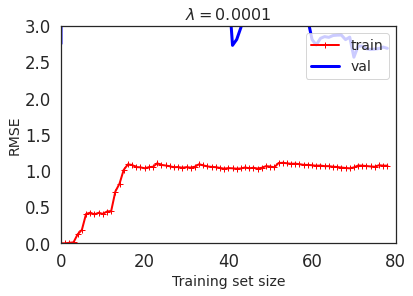

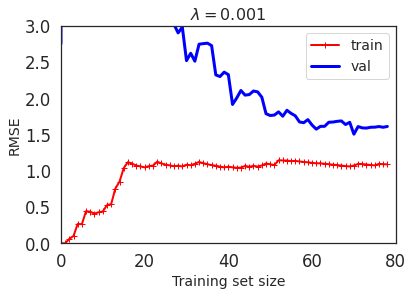

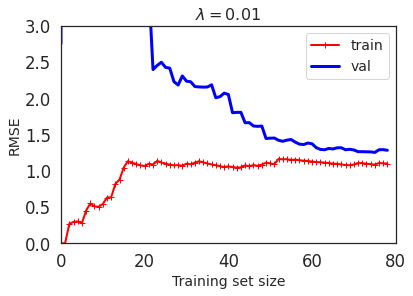

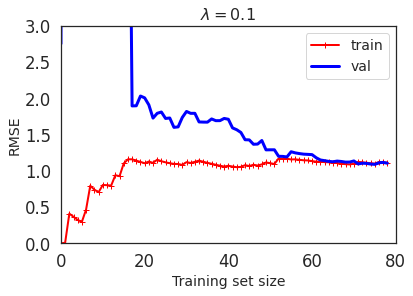

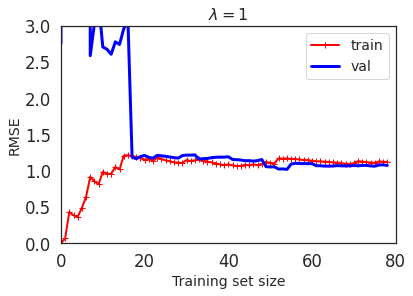

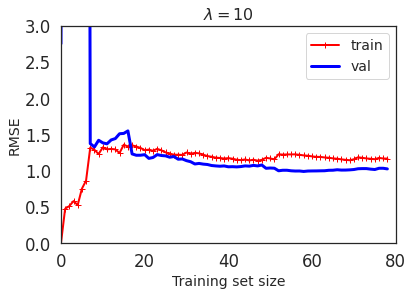

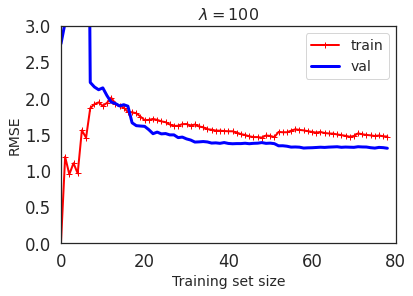

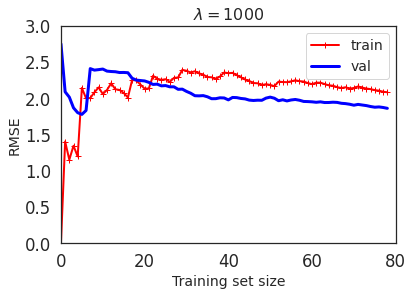

In [ ]:
for rr in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]:
  polynomial_regression = Pipeline([
                ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                ("std_scaler", StandardScaler()),
                ("ridge_reg", Ridge(alpha=rr, solver='cholesky')),
            ])

  plot_learning_curves(polynomial_regression, X, y)
  plt.axis([0, 80, 0, 3])
  plt.title(r"$\lambda = {}$".format(rr), fontsize=16)
  plt.show()

Instead of manually searching for the best hyperparameters, we can use `sklearn.model_selection.GridSearchCV` or  `sklearn.model_selection.RandomSearchCV`.



In [ ]:
# Add code here

This functionality of best hyperparameter search is available via `sklearn.linear_model.RidgeCV` predictor.

In [ ]:
from sklearn.linear_model import RidgeCV

polynomial_regression = Pipeline([
                ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                ("std_scaler", StandardScaler()),
                ("ridge_reg", RidgeCV(alphas=np.logspace(-6, 6, 13))),
            ])
polynomial_regression.fit(X, y)

Pipeline(memory=None,
         steps=[('poly_features',
                 PolynomialFeatures(degree=10, include_bias=False,
                                    interaction_only=False, order='C')),
                ('std_scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ridge_reg',
                 RidgeCV(alphas=array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]),
                         cv=None, fit_intercept=True, gcv_mode=None,
                         normalize=False, scoring=None,
                         store_cv_values=False))],
         verbose=False)

In [ ]:
# loss polynomial_regression['ridge_reg'].alpha_